### **<span style="background-color: yellow; color: black">2\. Trabajo de código: Flujo de Stokes</span>**

Resolveremos el problema del **flujo en una cavidad con pared móvil**. Asumimos que la pared superior de una cavidad cuadrada se desplaza a una velocidad constante $u = 1$, y no hay salida de fluido a través de la misma. Queremos visualizar el campo de flujo dentro de la cavidad en estado estacionario. Suponemos además condición de no deslizamiento en todas las superficies. Las condiciones de borde se escriben en términos de la función de corriente $\psi$.

![1](images/1.png)

NOTA: La solución del sistema acoplado para ambas variables $\psi$ y $\omega$ se llevará a cabo en forma iterativa hasta que la norma L1 de la diferencia entre iteraciones sucesivas sea menor que $10^{-6}$ para ambas cantidades. Utilice los siguientes parámetros en su simulación:


### **Nota de Implementación**

La solución para el sistema acoplado de las variables de **vorticidad ($\omega$)** y **función de corriente ($\psi$)** se obtendrá de forma iterativa. El proceso se detendrá cuando la **norma L1** de la diferencia entre las iteraciones sucesivas sea menor que $1 \times 10^{-6}$ para ambas cantidades.

```python
import numpy

# Set parameters
nx, ny = 41, 41  # number of points in each direction
L = 1.0          # length of the square cavity
dx = L/(nx-1)    # grid spacing in the x direction
dy = L/(ny-1)    # grid spacing in the y direction

def l1_norm(u, u_ref):
    """
    Computes and returns the L1-norm of the difference
    between a solution u and a reference solution u_ref.

    Parameters
    ----------
    u : numpy.ndarray
        The solution as an array of floats.
    u_ref : numpy.ndarray
        The reference solution as an array of floats.

    Returns
    -------
    diff : float
        The L2-norm of the difference.
    """
    diff = numpy.sum(numpy.abs(u - u_ref))
    return diff
```

Corrobore que el resultado final para la función de corriente en estado estacionario
se asemeje al siguiente campo de flujo:

![2](images/2.png)


### **<span style="background-color: yellow; color: black">2\. Trabajo de código: Flujo de Stokes - Respuesta</span>**


Este ejercicio trata sobre cómo simular el **flujo de Stokes** en una cavidad, un problema clásico de mecánica de fluidos. La idea es encontrar un estado de equilibrio para el flujo de un fluido muy viscoso dentro de una caja con una tapa móvil. Para lograr esto, se utilizan dos variables interconectadas: la **función de corriente ($\psi$)** y la **vorticidad ($\omega$)**.

El problema se resuelve de manera iterativa. Esto significa que comenzarás con una suposición inicial para $\psi$ y $\omega$ y luego, en cada paso, las actualizarás hasta que dejen de cambiar significativamente, lo que indica que el sistema ha alcanzado un **estado estacionario**. Para saber si has llegado a ese punto, usarás la **norma L1**.

Aquí tienes el código Python completo para simular este problema. Incluye la inicialización de los parámetros, el bucle principal de la simulación y las condiciones de borde.

El cálculo convergió en 2773 iteraciones.
Norma L1 final para psi: 2.3368637633287686e-08
Norma L1 final para omega: 9.954455422883606e-07


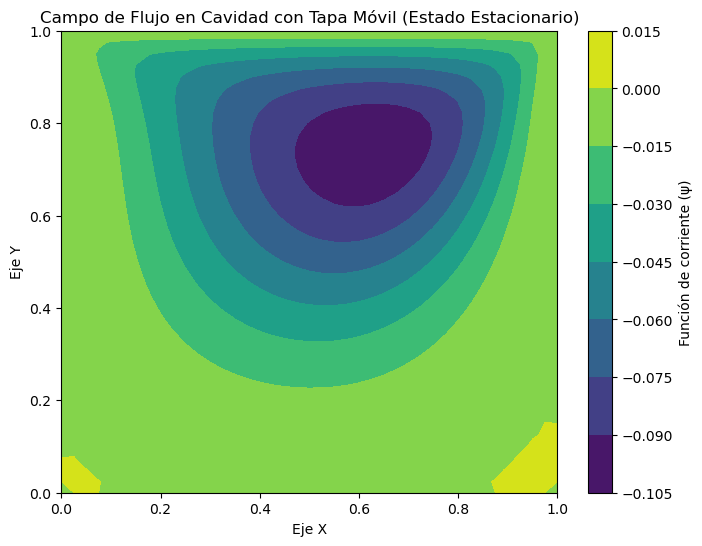

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
nx, ny = 41, 41        # número de puntos en cada dirección
L = 1.0                # longitud de la cavidad cuadrada
dx = L / (nx - 1)      # espaciamiento en x
dy = L / (ny - 1)      # espaciamiento en y
Re = 100.0             # número de Reynolds
l1_target = 1e-6       # tolerancia para la norma L1
U0 = 1.0               # velocidad de la tapa

# Inicialización de mallas
psi = np.zeros((ny, nx))
omega = np.zeros((ny, nx))
psi_previous = np.zeros((ny, nx))
omega_previous = np.zeros((ny, nx))

# Condiciones de borde para psi = 0 en todas las paredes
psi[0, :] = 0.0
psi[:, 0] = 0.0
psi[:, -1] = 0.0
psi[-1, :] = 0.0


def l1_norm(u, u_ref):
    """Calcula la norma L1 de la diferencia entre dos arrays."""
    return np.sum(np.abs(u - u_ref))


# Iteración
psi_diff = 1.0
omega_diff = 1.0
iterations = 0

# Bucle principal de la simulación
while psi_diff > l1_target or omega_diff > l1_target:

    # Guardar estado anterior
    psi_previous = psi.copy()
    omega_previous = omega.copy()

    # Resolver ecuación de Poisson para psi
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            psi[j, i] = 0.25 * (
                psi[j, i + 1] + psi[j, i - 1] +
                psi[j + 1, i] + psi[j - 1, i] +
                dx**2 * omega[j, i]
            )

    # Velocidades u y v a partir de psi (diferencias centrales)
    u = (psi[2:, 1:-1] - psi[0:-2, 1:-1]) / (2 * dy)
    v = -(psi[1:-1, 2:] - psi[1:-1, 0:-2]) / (2 * dx)

    # Actualizar omega (ecuación de transporte)
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            # Término difusivo
            diffusive_term = (
                omega_previous[j, i + 1] + omega_previous[j, i - 1] +
                omega_previous[j + 1, i] + omega_previous[j - 1, i]
            )

            # Velocidades en (i,j)
            u_ij = (psi_previous[j + 1, i] - psi_previous[j - 1, i]) / (2 * dy)
            v_ij = -(psi_previous[j, i + 1] - psi_previous[j, i - 1]) / (2 * dx)

            # Gradientes de omega
            du_dx = (omega_previous[j, i + 1] - omega_previous[j, i - 1]) / (2 * dx)
            dv_dy = (omega_previous[j + 1, i] - omega_previous[j - 1, i]) / (2 * dy)

            # Término convectivo
            convective_term = u_ij * du_dx + v_ij * dv_dy

            # Actualización
            omega[j, i] = 0.25 * diffusive_term - 0.25 * Re * (dx**2) * convective_term

    # Condiciones de borde para omega
    omega[0, :] = 2.0 * (psi[0, :] - psi[1, :]) / dy**2
    omega[-1, :] = (2.0 / dy**2) * (psi[-1, :] - psi[-2, :]) - 2.0 * U0 / dy
    omega[:, 0] = 2.0 * (psi[:, 0] - psi[:, 1]) / dx**2
    omega[:, -1] = 2.0 * (psi[:, -1] - psi[:, -2]) / dx**2

    # Norma L1 para verificar convergencia
    psi_diff = l1_norm(psi, psi_previous)
    omega_diff = l1_norm(omega, omega_previous)

    iterations += 1

print(f"El cálculo convergió en {iterations} iteraciones.")
print(f"Norma L1 final para psi: {psi_diff}")
print(f"Norma L1 final para omega: {omega_diff}")

# Coordenadas para los ejes
x = np.linspace(0.0, L, nx)
y = np.linspace(0.0, L, ny)

# Visualización del campo de flujo
plt.figure(figsize=(8, 6))
plt.contourf(x, y, psi, cmap="viridis")
plt.colorbar(label="Función de corriente (ψ)")
plt.title("Campo de Flujo en Cavidad con Tapa Móvil (Estado Estacionario)")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.show()
